# Testing a Machine learning strategy

We will be designing a strategy which combines signals from technical indicators and a machine learning algorithm. This document contains the performance of the algorithm and the description of the technical indicators. 

For details of the machine learning algorithm please see the ML_test and Xgboos_test files.
 

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Import packages
from datetime import datetime
import Methods as models
import Predictors as predictors
import stock_tools as st
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import ML_predict as strat

We were given the following starting conditions.

In [3]:
interest = 'SPY'
start_date = datetime.strptime('2000-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2010-12-31', '%Y-%m-%d')
initial_capital = 100000
cost = 0.025

I have written a function to get the data from Yahoo finance. The data already has corrected closing prices. I also adjust the Opening, Low and High fields to make adjusted data. 

In [4]:
data = st.get_data(start_date,end_date,from_file=True)
corr_data = st.ohlc_adj(data)

## Tecnical indicators

I have written a class to create technical indicators which may be used later. The details on each indicator can be found in the class file. 

In [5]:
pred = predictors.Predictors(corr_data)

The data is far too noisy to make accurate predictions. We apply a 5 day exponential rolling filter. This should preserve shape and reduce noise.

In [6]:
pred.e_filter(5)

I will describe here a few indicators which I feel are useful for the classical part:
* Moving Averages
* Stochastic Oscillator
* Average convergence

There are also indicators which were used in machine learning

* Momentum (*)
* Average fractal

(*) Momentum will not be discussed as it's a part of the average convergence

### Moving Averages

This is one of the simplest methods of determining trends. We take a fast average and a slow average, of the stock price.

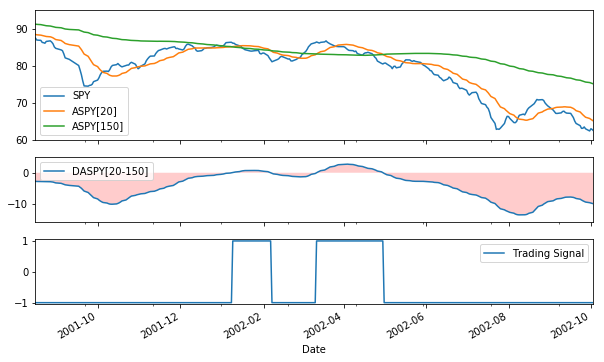

In [9]:
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
ax1 = plt.subplot(gs[0])
pred.data.Close.plot(label='SPY', legend=True)
pred.make_splits(20, inplace=False).plot(label='ASPY[20]', legend=True)
pred.make_splits(150, inplace=False).plot(label='ASPY[150]', legend=True)
plt.ylim([60, 95])
ax2 = plt.subplot(gs[1], sharex=ax1)
diff = (pred.make_splits(20, inplace=False) - pred.make_splits(150, inplace=False))
diff.plot(label='DASPY[20-150]', legend=True)
plt.fill_between(diff.index,diff.values,facecolor='r', alpha=0.2)
plt.ylim(-16,5)
ax3 = plt.subplot(gs[2],sharex=ax1)
pred.movingA_signal(20,150).plot(label="Trading Signal", legend=True)
plt.ylim(-1.05,1.05)
plt.xlim([730712.92, 731125.75])
plt.show()

When ASPY[Fast] is greater than ASPY[Slow], the local movement of the index is greater than in history and indicates that the trend is for the price to increase. The problem is that the averages create a lag and a price move might occur before.

### Stochastic Oscillator

This is a comparison between the current price to the historic high and low prices and converted to a percentage. It might indicate when a movement is bottoming out.

$$ SO = 100*\frac{(SPY.Close - min(SPY[14])}{max(SPY[14]) - min(SPY[14])} $$

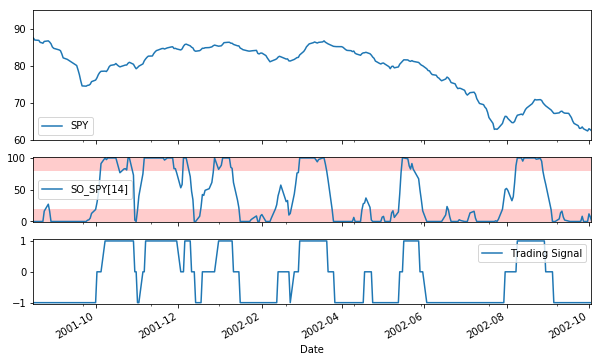

In [10]:
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
ax1 = plt.subplot(gs[0])
pred.data.Close.plot(label='SPY', legend=True)
plt.ylim([60, 95])
ax2 = plt.subplot(gs[1], sharex=ax1)
pred.make_stokO(14).plot(label='SO_SPY[14]', legend=True)
ax2.axhspan(-1, 20, facecolor='r', edgecolor='none', alpha=.2)
ax2.axhspan(80, 101, facecolor='r', edgecolor='none', alpha=.2)
plt.ylim([-1, 101])
ax3 = plt.subplot(gs[2],sharex=ax1)
pred.stokO_signal().plot(label="Trading Signal", legend=True)
plt.ylim(-1.05,1.05)
plt.xlim([730712.92, 731125.75])
plt.show()

### Average convergence

For this indicator we look at how the averages are converging or diverging. We take the exponential mean and calculate the difference between the fast and slow means. This gives a measure of positive or negative market momentum. Taking an n-day average of this gives an impression on the previous momentum trend and the difference between the average and measure of momentum tells us when a crossover has happened.

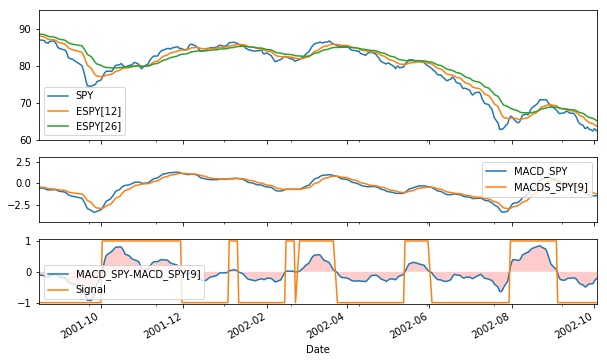

In [11]:
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
ax1 = plt.subplot(gs[0])
pred.data.Close.plot(label='SPY', legend=True)
pred.make_esplits(12, inplace=False).plot(label='ESPY[12]', legend=True)
pred.make_esplits(26, inplace=False).plot(label='ESPY[26]', legend=True)
plt.ylim([60, 95])
ax2 = plt.subplot(gs[1], sharex=ax1)
pred.MACD().plot(label='MACD_SPY', legend=True)
pred.MACD_signal_line().plot(label='MACDS_SPY[9]', legend=True)
plt.ylim(-4.5,3)
ax3 = plt.subplot(gs[2],sharex=ax1)
temp = pred.MACD_signal_line(hist=True)
temp.plot(label="MACD_SPY-MACD_SPY[9]", legend=True)
pred.MACD_signal_line(hist=True,signal=True).plot(label="Signal", legend=True)
plt.fill_between(temp.index,temp.values,facecolor='r', alpha=0.2)
plt.ylim(-1.05,1.05)
plt.xlim([730712.92, 731125.75])
plt.show()

### Fractal Averaging 

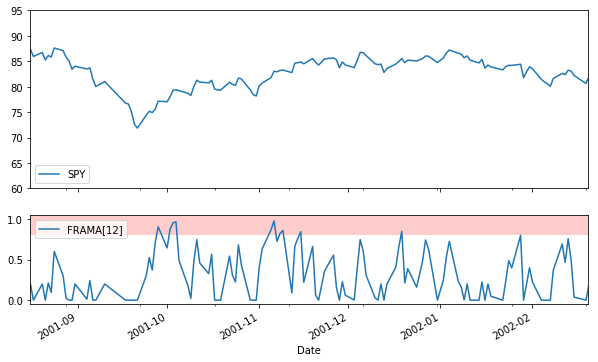

In [55]:
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
pred.data.Close.plot(label='SPY', legend=True)
plt.ylim([60, 95])
ax2 = plt.subplot(gs[1], sharex=ax1)
pred.props.meanfractal.plot(label='FRAMA[12]', legend=True)
ax2.axhspan(0.8, 1.05, facecolor='r', edgecolor='none', alpha=.2)
plt.ylim([-0.05, 1.05])
plt.xlim([730712.92, 730900.75])
plt.show()

This is a smarter version of the moving average and moving exponential averages moved above. It take the the rolling mean of the fractal dimension. This fractal dimension is the sum of measure multiplied by the previous fractal dimension, which extends back a number of days (N) from date (i). 

Our interpretation is designed to find when the price is going to increase:

$$ F(i,N) = \frac{1}{N} \sum^{N}_{j=1} L(i,N) \frac{(SPY.Close[i] - SPY.Close[i-j])}{\frac{1}{j}\sum^{j}_{k=1}(SPY.Close[i] - SPY.Close[i-k])}$$

Where $L(i,N)$ is 0 if $(SPY.Close[i] - SPY.Close[i-j]) < 0 $ and 1 otherwise

A detailed description on Fractal theory can be found [here](https://goo.gl/jSRgF9)

## Momentum based strategy

This is a rolling momentum strategy, where the moving averages, stochastic Oscillator and average convergence are taken into account. Note that this could be optimised by choosing parameters correctly, but since it is not the aim of my submission to build a strategy based on crossover signals it has not been done so.

/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


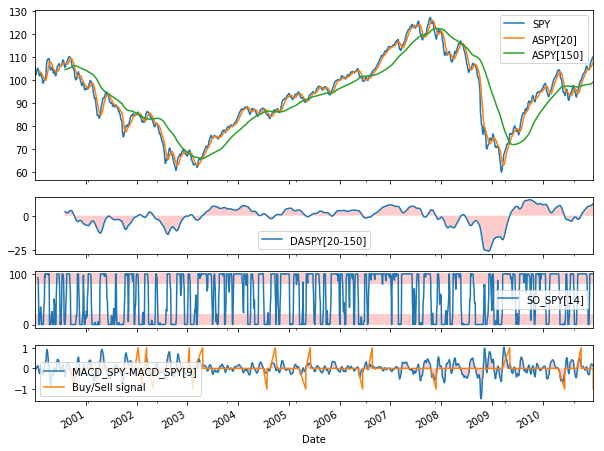

In [7]:
pred_B = predictors.Predictors(corr_data)
pred_B.e_filter(5)
trades_raw = pred_B.movAVG_BuySell()
plt.show()

We see buy and sell signals were generated when the three conditions for DASPY, SO_SPY and MACD-MACD[9] were met. Now this can be backtested on previous data

In [10]:
trades_raw.to_csv('basic_trades.csv', sep=',')
trades_period = st.fillin_low_periods(trades_raw,corr_data) # This is for seeing if a stop/loss is triggered
# Note that we DON'T use the smoothed data for backtesting.
results = st.backtest(trades_period,initial_capital,commission=0.0025)

In this simulation we are using 10% of our cash to buy 100 batches of shares. We will stop a trade and not use the computed date if the value goes below 20% of the starting value.

In [8]:
# Just some fancy plotting
def highlight_trades(idx,ax,color='green'):
    i=0
    while i<len(idx):
        if idx[i] == idx[i+1]:
            ax.axvspan(idx[i]-pd.Timedelta(1, unit='d'), idx[i + 1]+pd.Timedelta(1, unit='d'), facecolor=color, edgecolor='none', alpha=.2)
        else:
            ax.axvspan(idx[i], idx[i+1], facecolor=color, edgecolor='none', alpha=.2)
        i+=2

So, how did we do?

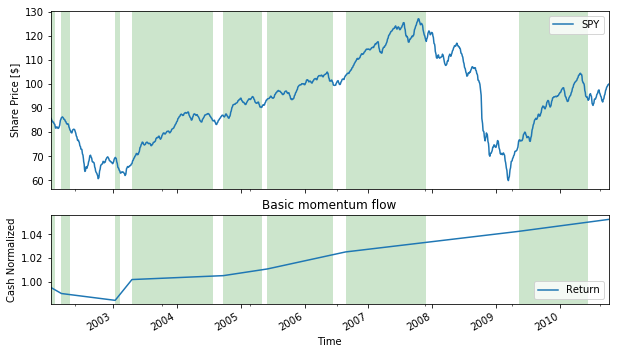

In [11]:
# Plot our benchmark
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
corr_data.Close.plot(label="SPY", legend=True)
ax1.set_ylabel("Share Price [$]")
ax2 = plt.subplot(gs[1],sharex=ax1)
results["End Port. Value"].div(initial_capital).plot(label="Return", legend=True)
ax2.set_xlabel("Time")
ax2.set_ylabel("Cash Normalized")
highlight_trades(trades_raw.index,ax1)
highlight_trades(trades_raw.index,ax2)
plt.title("Basic momentum flow")

Trading periods are shown in green. We have made 40,000 by investing 10,000 each time.

## Machine lerning strategy

The details on how the logic was modeled can be found in the ML_test and ML_predict files. A brief summary is that I used the _A_ _meanfractal_, _Stok0_, _mom_, _MACD_ parameters in a random forrest supervised learning model to predict the next days percentage change. Based on this I decided if a trade can be made.

So I will just make trades in the period where the momentum strategy did not see profit.

In [12]:
corr_new = corr_data.copy()
# Can we make extra profit by predicting the future?
corr_new["Avail"] = 0
corr_new.ix[corr_data.index[0]:trades_raw.index[0],"Avail"] = 1
for i in range(1,len(trades_raw)-1,2):
    corr_new.ix[trades_raw.index[i]:trades_raw.index[i + 1],"Avail"] = 1


# We now have a dataset where trades can be made.
pred_R = corr_new[corr_new.Avail == 1]
# This is the difference in daily percentage which we will look at
logic = (1 - pred.data.Close.shift(1).div(pred.data.Close))

Now we have the periods we perform a simulation for each day to see if the price will rise or fall by a percentage.

In [ ]:
# Start the simulation loop
days_previous = 252 # This is the number of previous days to study
trades = pd.DataFrame({"Price": [],"Regime": [], "Signal": []}) # Empty dataframe to put trades.
# Cycle through each day and simulate
for i in range(len(pred_R)):
    # Check if we have enough previous data
    if pred_R.index[i] > pred.props.index[days_previous+1]:
        # Do the simulation. See ML_BuySell.py for details.
        bs = strat.ML_BuySell(pred.props, pred_R.index[i], {'meanfractal', 'RStok0', 'mom', 'MACD_l'}, logic)
        if bs is not None:
            trades = pd.concat([trades,bs])

In [13]:
loadTrades= True
if loadTrades:
    trades = pd.read_csv('ml_trades_gap.csv',index_col=0, parse_dates=True)
    
else:
    trades.to_csv('ml_trades_gap.csv', sep=',')

Now we have our predictions we can backtest them

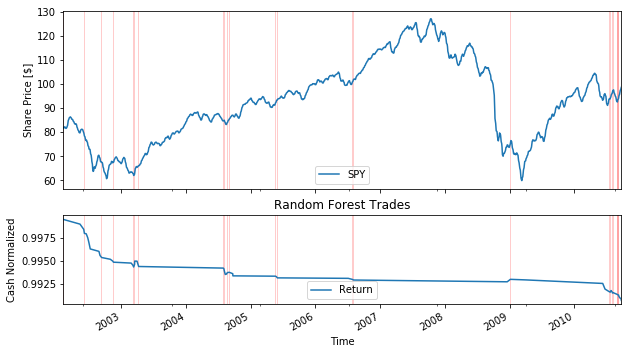

In [14]:
# Fill in the low periods.
trades_period2 = st.fillin_low_periods(trades,corr_data,daily=True)
# Note that we DON'T use the smoothed data for backtesting.
results2 = st.backtest(trades_period2,initial_capital,commission=0.0025)

# Plot our strategy.
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
corr_data.Close.plot(label="SPY", legend=True)
ax1.set_ylabel("Share Price [$]")
ax2 = plt.subplot(gs[1],sharex=ax1)
results2["End Port. Value"].div(initial_capital).plot(label="Return", legend=True)
ax2.set_xlabel("Time")
ax2.set_ylabel("Cash Normalized")
highlight_trades(trades.index,ax1,'r')
highlight_trades(trades.index,ax2,'r')
plt.title("Random Forest Trades")
plt.show()

Well, that doesnt look promising, but it does not tell the whole story. In actual fact it was the comission which ate up all the profits.

Our accuracy was:

In [15]:
acc = (results2["Total Profit"]<0).sum()/(results2["Total Profit"]>0).sum()
print(acc)

0.564102564103


So, how does it all look together?

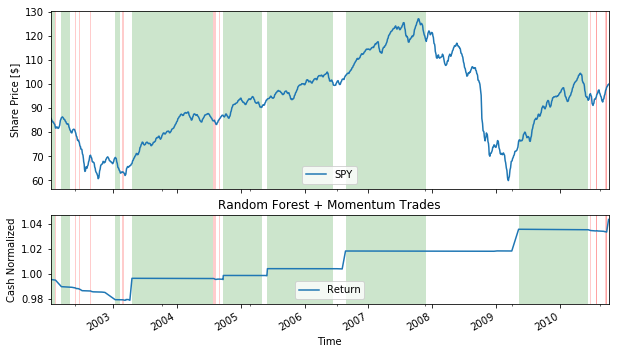

In [16]:
trades_tot = pd.concat([trades_raw,trades])
trades_period3 = st.fillin_low_periods(trades_tot,corr_data)
Results_total = st.backtest(trades_period3,initial_capital,commission=0.0025)

# And now both together
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
ax1 = plt.subplot(gs[0])
corr_data.Close.plot(label="SPY", legend=True)
ax1.set_ylabel("Share Price [$]")
ax2 = plt.subplot(gs[1],sharex=ax1)
Results_total["End Port. Value"].div(initial_capital).plot(label="Return", legend=True)
ax2.set_xlabel("Time")
ax2.set_ylabel("Cash Normalized")
highlight_trades(trades_raw.index,ax1)
highlight_trades(trades_raw.index,ax2)
highlight_trades(trades.index,ax1,'r')
highlight_trades(trades.index,ax2,'r')
plt.title("Random Forest + Momentum Trades")
plt.savefig("RF+M_return.png")
plt.show()